# TelecomX - Parte 2: Predicción de Churn con Machine Learning

Misión: desarrollar modelos predictivos robustos para identificar qué clientes tienen mayor probabilidad de cancelar sus servicios, permitiendo a la empresa anticiparse al problema de churn.


In [3]:
#Importación de librerías
import pandas as pd
import numpy as np
import json
from warnings import filterwarnings
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,confusion_matrix, classification_report, roc_auc_score, roc_curve)
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE


In [13]:
import pandas as pd
import numpy as np
import json
import os

archivo = 'TelecomX_Data.json'
registro_log = []
if not os.path.exists(archivo):
    raise FileNotFoundError(f"No se encontró '{archivo}'. Colócalo en la carpeta actual.")

with open(archivo, 'r', encoding='utf-8') as f:
    raw_data = json.load(f)

registro_log.append(f"Cargado: {len(raw_data)} registros desde {archivo}")


df = pd.json_normalize(raw_data)

# Renombrar columnas para que sean simples (eliminando prefijos como 'customer.', 'account.', etc.)
column_mapping = {
    'customerID': 'customerID',
    'Churn': 'Churn',
    'customer.gender': 'gender',
    'customer.SeniorCitizen': 'SeniorCitizen',
    'customer.Partner': 'Partner',
    'customer.Dependents': 'Dependents',
    'customer.tenure': 'tenure',
    'phone.PhoneService': 'PhoneService',
    'phone.MultipleLines': 'MultipleLines',
    'internet.InternetService': 'InternetService',
    'internet.OnlineSecurity': 'OnlineSecurity',
    'internet.OnlineBackup': 'OnlineBackup',
    'internet.DeviceProtection': 'DeviceProtection',
    'internet.TechSupport': 'TechSupport',
    'internet.StreamingTV': 'StreamingTV',
    'internet.StreamingMovies': 'StreamingMovies',
    'account.Contract': 'Contract',
    'account.PaperlessBilling': 'PaperlessBilling',
    'account.PaymentMethod': 'PaymentMethod',
    'account.Charges.Monthly': 'MonthlyCharges',
    'account.Charges.Total': 'TotalCharges'
}

df = df.rename(columns=column_mapping)
df = df[column_mapping.values()]

registro_log.append("Estructura JSON aplanada con pandas")

# Conversión segura de columnas numéricas sin funciones
# Usamos pd.to_numeric con errors='coerce' para convertir de forma robusta
for col in ['MonthlyCharges', 'TotalCharges']:
    # Reemplazar cadenas vacías, espacios o nulos por NaN
    df[col] = df[col].astype(str).replace(r'^\s*$', np.nan, regex=True)
    df[col] = pd.to_numeric(df[col], errors='coerce')
    df[col] = df[col].fillna(0.0)  # Imputar NaN como 0.0

registro_log.append("Conversión segura de cargos mensuales y totales")

#Limpieza de Churn
df['Churn'] = df['Churn'].replace({'': np.nan, ' ': np.nan})
df = df.dropna(subset=['Churn']).reset_index(drop=True)
registro_log.append(f"Limpiados valores faltantes en Churn")

#Corregir TotalCharges cuando es 0 pero tenure > 0
condicion_correccion = (df['TotalCharges'] == 0) & (df['tenure'] > 0)
num_corregidos = condicion_correccion.sum()

if num_corregidos > 0:
    df.loc[condicion_correccion, 'TotalCharges'] = (
        df.loc[condicion_correccion, 'MonthlyCharges'] *
        df.loc[condicion_correccion, 'tenure']
    )
    registro_log.append(f"Corregidos {num_corregidos} registros con TotalCharges = 0 pero tenure > 0")

# Métricas finales
registro_log.append(f"Dataset final: {len(df):,} registros, {len(df.columns)} columnas")

# Mostrar resumen
print("\n".join(registro_log))

#Distribución de Churn
if 'Churn' in df.columns:
    churn_count = df['Churn'].value_counts()
    print("\nDistribución de Churn:")
    for valor, conteo in churn_count.items():
        porcentaje = (conteo / len(df)) * 100
        print(f"   • {valor}: {conteo:,} ({porcentaje:.1f}%)")

#Listo para ML
print("\n **Datos listos para modelado de Machine Learning**")

#Muestra de datos
try:
    display(df.head())
except NameError:
    print("\n📋 Muestra de datos:")
    print(df.head())

Cargado: 7267 registros desde TelecomX_Data.json
Estructura JSON aplanada con pandas
Conversión segura de cargos mensuales y totales
Limpiados valores faltantes en Churn
Dataset final: 7,043 registros, 21 columnas

Distribución de Churn:
   • No: 5,174 (73.5%)
   • Yes: 1,869 (26.5%)

 **Datos listos para modelado de Machine Learning**


,customerID,Churn,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,...,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,...,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.30
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,...,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.40
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,...,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85
3,0011-IGKFF,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,...,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85
4,0013-EXCHZ,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,...,No,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.40


ANÁLISIS DE DESBALANCE
Distribución de clases:
   No: 5,174 (73.46%)
   Yes: 1,869 (26.54%)

 Métricas de desbalance:
   Ratio: 2.77:1
   Clase mayoritaria: No (5,174)
   Clase minoritaria: Yes (1,869)

 Estado: LIGERAMENTE DESBALANCEADO
Recomendación: Considerar ajustar pesos en modelos


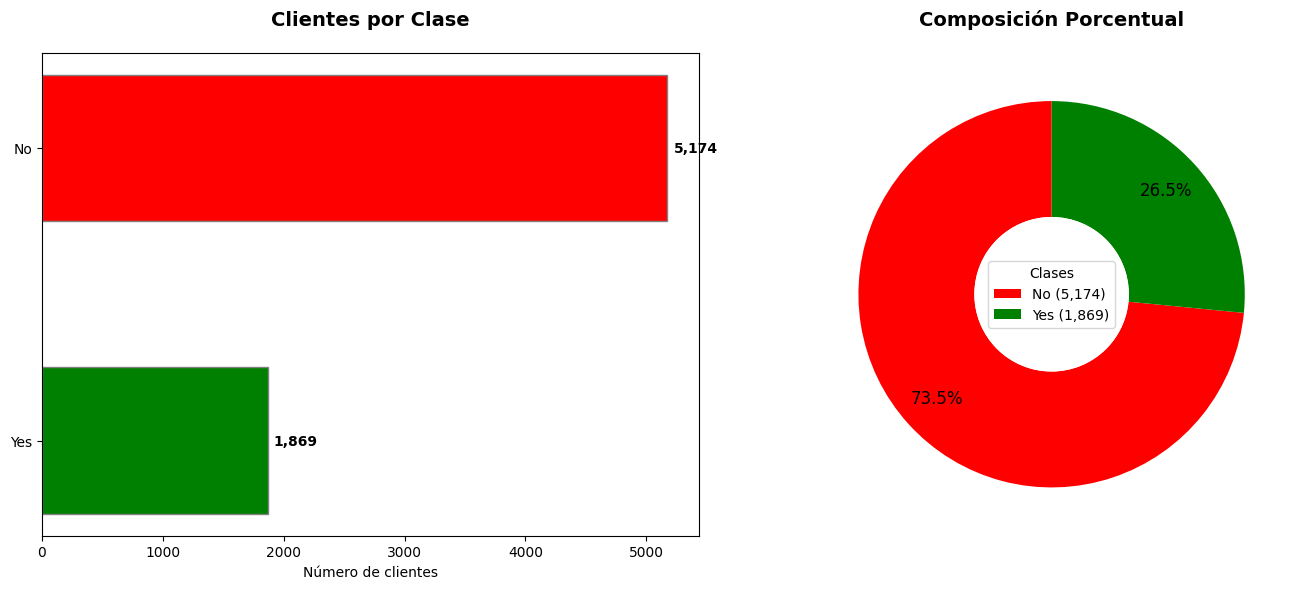


 Métricas guardadas para ML: ratio=2.768, requiere_balanceo=True


In [15]:
import matplotlib.pyplot as plt
import numpy as np

print("ANÁLISIS DE DESBALANCE")


#Cálculo vectorizado de conteos y porcentajes
unique, counts = np.unique(df['Churn'].values, return_counts=True)
churn_map = dict(zip(unique, counts))
porcentajes = 100 * counts / counts.sum()

#Métricas clave
mayoritaria_idx = counts.argmax()
minoritaria_idx = counts.argmin()
ratio = counts[mayoritaria_idx] / counts[minoritaria_idx]

# Distribución con formato compacto
clases_info = [f"   {cls}: {cnt:,} ({pct:.2f}%)" for cls, cnt, pct in zip(unique, counts, porcentajes)]
print("Distribución de clases:")
print("\n".join(clases_info))
#Clasificación del desbalance con lógica embebida
nivel = (
    "BALANCEADO" if ratio <= 1.5 else
    "LIGERAMENTE DESBALANCEADO" if ratio <= 3.0 else
    "MODERADAMENTE DESBALANCEADO" if ratio <= 10.0 else
    "MUY DESBALANCEADO"
)

recomendacion = {
    "BALANCEADO": "No se requieren técnicas de balanceo especiales",
    "LIGERAMENTE DESBALANCEADO": "Considerar ajustar pesos en modelos",
    "MODERADAMENTE DESBALANCEADO": "Recomendado usar SMOTE o class_weight",
    "MUY DESBALANCEADO": "Técnicas de balanceo son críticas"
}[nivel]

#Métricas de desbalance
print(f"\n Métricas de desbalance:")
print(f"   Ratio: {ratio:.2f}:1")
print(f"   Clase mayoritaria: {unique[mayoritaria_idx]} ({counts[mayoritaria_idx]:,})")
print(f"   Clase minoritaria: {unique[minoritaria_idx]} ({counts[minoritaria_idx]:,})")

print(f"\n Estado: {nivel}")
print(f"Recomendación: {recomendacion}")

# Visualización: gráfico combinado (barras + porcentajes en una sola figura)
fig = plt.figure(figsize=(14, 6))

# Subplot 1: Barras horizontales (inversión de estilo)
ax1 = plt.subplot(1, 2, 1)
bars = ax1.barh(unique[::-1], counts[::-1], color=['green', 'red'], edgecolor='gray', height=0.5)
ax1.set_title("Clientes por Clase", fontsize=14, fontweight='bold', pad=20)
ax1.set_xlabel("Número de clientes")
# Etiquetas internas en barras
for bar, count in zip(bars, counts[::-1]):
    ax1.text(count + 50, bar.get_y() + bar.get_height()/2, f'{count:,}',
             va='center', ha='left', fontweight='bold', fontsize=10)

# Subplot 2: Anillo (doughnut) personalizado
ax2 = plt.subplot(1, 2, 2)
colores = ['red', 'green']
# Gráfico de anillo
ax2.pie(porcentajes, labels=None, autopct='%1.1f%%', startangle=90, colors=colores,
        wedgeprops=dict(width=0.6), pctdistance=0.8, textprops={'fontsize': 12})
# Círculo interno para efecto doughnut
centre_circle = plt.Circle((0,0), 0.4, fc='white')
ax2.add_artist(centre_circle)
# Leyenda personalizada fuera del gráfico
ax2.legend([f"{lbl} ({cnt:,})" for lbl, cnt in zip(unique, counts)],
           title="Clases", loc="center", bbox_to_anchor=(0.5, 0.5), fontsize=10)

ax2.set_title("Composición Porcentual", fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

# Guardado de métricas para modelos futuros
class_distribution = {
    'counts': {cls: int(cnt) for cls, cnt in churn_map.items()},
    'proportions': {cls: round(pct / 100, 4) for cls, pct in zip(unique, porcentajes)},
    'imbalance_ratio': float(f"{ratio:.3f}"),
    'needs_balancing': ratio > 2.0
}
print(f"\n Métricas guardadas para ML: ratio={class_distribution['imbalance_ratio']}, "
      f"requiere_balanceo={class_distribution['needs_balancing']}")

In [16]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder

#PREPARACIÓN DE DATOS
df_ml = df.drop(columns=['customerID'], errors='ignore').copy()
print("Dataset inicial:")
print(f"Forma: {df_ml.shape}")
print(f"Columnas: {len(df_ml.columns)}")
es_binaria = (
    (df_ml.nunique() == 2) &
    (df_ml.apply(lambda s: set(s.dropna().unique()) <= {'Yes', 'No', 'No internet service', 'No phone service'})))
es_numerica = df_ml.dtypes.apply(lambda dt: np.issubdtype(dt, np.number))
binary_cols = df_ml.columns[es_binaria & ~df_ml.columns.isin(['Churn'])].tolist()
numeric_cols = df_ml.columns[es_numerica & ~df_ml.columns.isin(['Churn'])].tolist()
categorical_cols = df_ml.columns[
    (~es_binaria) &
    (df_ml.dtypes == 'object') &
    (~df_ml.columns.isin(['Churn']))
].tolist()

print(f"\n Tipos de variables detectados:")
print(f"   Binarias (Yes/No): {len(binary_cols)} → {binary_cols}")
print(f"   Numéricas: {len(numeric_cols)} → {numeric_cols}")
print(f"   Categóricas múltiples: {len(categorical_cols)} → {categorical_cols}")
df_encoded = df_ml.copy()
df_encoded['Churn'] = (df_encoded['Churn'] == 'Yes').astype(int)
for col in binary_cols:
    df_encoded[col] = df_encoded[col].map({'Yes': 1, 'No': 0}).fillna(0).astype(int)
servicio_internet = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
for col in servicio_internet:
    if col in df_encoded.columns:
        conditions = [
            df_encoded[col] == 'Yes',
            df_encoded[col] == 'No',
            df_encoded[col] == 'No internet service'
        ]
        choices = [1, 0, -1]
        df_encoded[col] = np.select(conditions, choices, default=0).astype(int)
if 'MultipleLines' in df_encoded.columns:
    conditions = [
        df_encoded['MultipleLines'] == 'Yes',
        df_encoded['MultipleLines'] == 'No',
        df_encoded['MultipleLines'] == 'No phone service'
    ]
    choices = [1, 0, -1]
    df_encoded['MultipleLines'] = np.select(conditions, choices, default=0).astype(int)

print(f"Codificación de servicios completada con np.select")
df_encoded = pd.get_dummies(df_encoded, columns=categorical_cols, prefix=categorical_cols, dtype=int)

print(f" One-Hot aplicado a {len(categorical_cols)} variables categóricas")
print(f"   Forma final del dataset: {df_encoded.shape}")
print(f"   Total de características (features): {df_encoded.shape[1] - 1}")
print(f"   Variable objetivo: Churn (0=No, 1=Yes)")
missing_total = df_encoded.isnull().sum().sum()
print(f"\n Validación de integridad:")
print(f"   Valores faltantes: {missing_total}")
print(f"   Tipos de datos numéricos: {np.sum(df_encoded.dtypes.apply(np.issubdtype, args=(np.number,)))}/{len(df_encoded.columns)}")

if missing_total == 0:
  print("\nDataset 'df_final' listo..!!!")
  df_final = df_encoded.copy()

else:
    print("Requiere imputación adicional")

# 📋 Vista previa
print(f"\n Estas son las primeras 5 filas del dataset final:")
try:
    display(df_final.head(5))
except NameError:
    print(df_final.head(5))

Dataset inicial:
Forma: (7043, 20)
Columnas: 20

 Tipos de variables detectados:
   Binarias (Yes/No): 4 → ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']
   Numéricas: 4 → ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']
   Categóricas múltiples: 11 → ['gender', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod']
Codificación de servicios completada con np.select
 One-Hot aplicado a 11 variables categóricas
   Forma final del dataset: (7043, 42)
   Total de características (features): 41
   Variable objetivo: Churn (0=No, 1=Yes)

 Validación de integridad:
   Valores faltantes: 0
   Tipos de datos numéricos: 42/42

Dataset 'df_final' listo..!!!

 Estas son las primeras 5 filas del dataset final:


,Churn,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,gender_Female,...,StreamingMovies_-1,StreamingMovies_0,StreamingMovies_1,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,1,1,9,1,1,65.6,593.30,1,...,0,1,0,0,1,0,0,0,0,1
1,0,0,0,0,9,1,0,59.9,542.40,0,...,0,0,1,1,0,0,0,0,0,1
2,1,0,0,0,4,1,1,73.9,280.85,0,...,0,1,0,1,0,0,0,0,1,0
3,1,1,1,0,13,1,1,98.0,1237.85,0,...,0,0,1,1,0,0,0,0,1,0
4,1,1,1,0,3,1,1,83.9,267.40,1,...,0,1,0,1,0,0,0,0,0,1


Rank Feature                      Corr     Efecto       Fuerza    
────────────────────────────────────────────────────────────
1    Contract_Month-to-month      +0.4051 🔴 Positivo   Fuerte    
2    tenure                       -0.3522 🔵 Negativo   Fuerte    
3    OnlineSecurity_0             +0.3426 🔴 Positivo   Fuerte    
4    TechSupport_0                +0.3373 🔴 Positivo   Fuerte    
5    InternetService_Fiber optic  +0.3080 🔴 Positivo   Fuerte    
6    Contract_Two year            -0.3023 🔵 Negativo   Fuerte    
7    PaymentMethod_Electronic check +0.3019 🔴 Positivo   Fuerte    
8    OnlineBackup_0               +0.2680 🔴 Positivo   Moderado  
9    DeviceProtection_0           +0.2525 🔴 Positivo   Moderado  
10   OnlineBackup_-1              -0.2279 🔵 Negativo   Moderado  
11   StreamingMovies_-1           -0.2279 🔵 Negativo   Moderado  
12   TechSupport_-1               -0.2279 🔵 Negativo   Moderado  
13   StreamingTV_-1               -0.2279 🔵 Negativo   Moderado  
14   OnlineS

<Figure size 1800x1200 with 0 Axes>

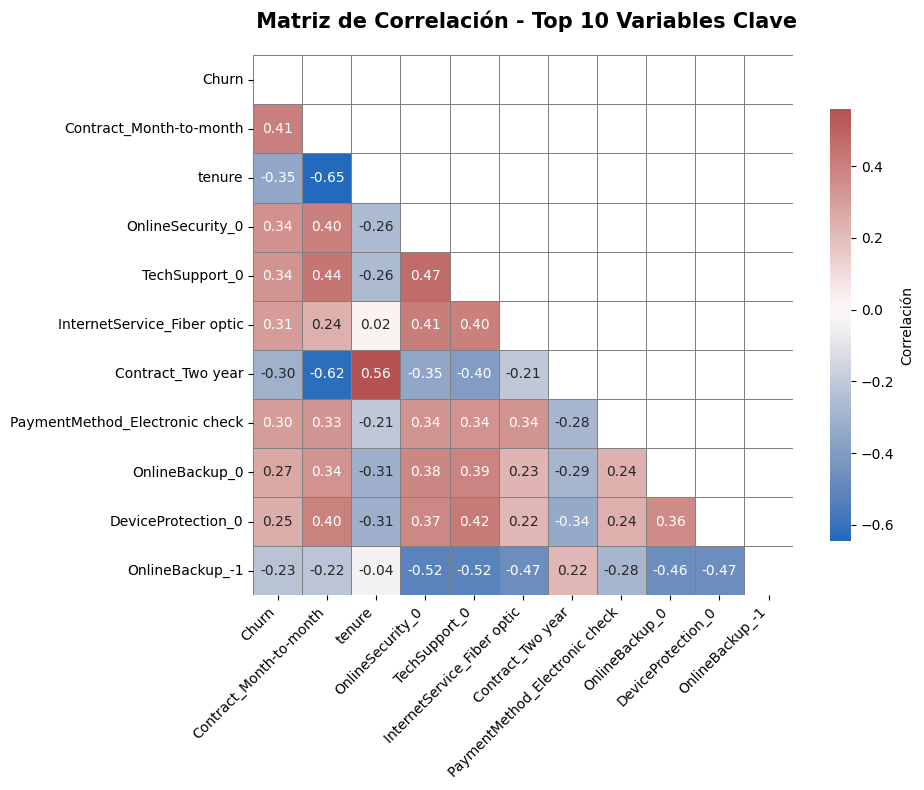

/tmp/ipython-input-3161890883.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_final, x='Churn', y='MonthlyCharges', palette=['#a6cee3', '#fb9a99'], ax=ax4)


<Figure size 640x480 with 0 Axes>


33 pares con multicolinealidad (|r| > 0.7):
gender_Female ↔ gender_Male: -1.0000
DeviceProtection_-1 ↔ StreamingMovies_-1: +1.0000
PhoneService ↔ MultipleLines_-1: -1.0000
InternetService_No ↔ StreamingTV_-1: +1.0000
InternetService_No ↔ DeviceProtection_-1: +1.0000
InternetService_No ↔ OnlineBackup_-1: +1.0000
InternetService_No ↔ TechSupport_-1: +1.0000
InternetService_No ↔ OnlineSecurity_-1: +1.0000
 Considera PCA o eliminación de una variable por par

 FEATURES RELEVANTES (|r| > 0.1): 30
   Contract_Month-to-month, tenure, OnlineSecurity_0, TechSupport_0, InternetService_Fiber optic, Contract_Two year, PaymentMethod_Electronic check, OnlineBackup_0, DeviceProtection_0, OnlineBackup_-1, StreamingMovies_-1, TechSupport_-1...

 RESUMEN:
   Media: 0.1742
 Mediana: 0.1712
    >0.1: 30.0
    >0.2: 16.0
    >0.3: 7.0


In [7]:

corr_matrix = df_final.corr(numeric_only=True)
churn_corr = corr_matrix['Churn'].drop('Churn').sort_values(key=abs, ascending=False)
top_15 = churn_corr.head(15)
header = f"{'Rank':<4} {'Feature':<28} {'Corr':<8} {'Efecto':<12} {'Fuerza':<10}"
separator = "─" * 60
print(header)
print(separator)
rows = [
    f"{i+1:<4} {feat:<28} {corr:+.4f} {'🔴 Positivo' if corr > 0 else '🔵 Negativo':<12} "
    f"{'Fuerte' if abs(corr) > 0.3 else 'Moderado' if abs(corr) > 0.1 else 'Débil':<10}"
    for i, (feat, corr) in enumerate(top_15.items())
]
print("\n".join(rows))
umbral_fuerza = 0.2
fuertes_pos = churn_corr[churn_corr > umbral_fuerza]
fuertes_neg = churn_corr[churn_corr < -umbral_fuerza]

print(f"\n Que econtramos:")
print(f" {len(fuertes_pos)} factores con correlación positiva > {umbral_fuerza}")
print(f" {len(fuertes_neg)} factores con correlación negativa < -{umbral_fuerza}")
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, width_ratios=[1, 1, 0.1], height_ratios=[1, 1, 1])
top_10_features = churn_corr.head(10).index.tolist()  # Top 10 más relevantes
subset_features = ['Churn'] + top_10_features  # Incluir Churn para ver todas las correlaciones
corr_subset = df_final[subset_features].corr()
plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(corr_subset, dtype=bool))
sns.heatmap(
    corr_subset,
    mask=mask,
    annot=True,
    fmt=".2f",
    cmap="vlag",
    center=0,
    square=True,
    cbar_kws={"shrink": 0.8, "label": "Correlación"},
    linewidths=0.5,
    linecolor='gray'
)
plt.title(" Matriz de Correlación - Top 10 Variables Clave", fontsize=15, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()

ax2 = fig.add_subplot(gs[1, :2])
colors = np.where(top_15.values > 0, '#d62728', '#1f77b4')  # rojo/azul
bars = ax2.barh(range(len(top_15))[::-1], top_15.values, color=colors, alpha=0.8, edgecolor='gray', linewidth=0.8)
ax2.set_yticks(range(len(top_15))[::-1])
ax2.set_yticklabels([f"{feat} ({corr:+.3f})" for feat, corr in top_15.items()], fontsize=9)
ax2.set_xlabel("Coeficiente de Correlación con Churn", fontsize=11)
ax2.axvline(0, color='black', linewidth=0.8, linestyle='--', alpha=0.7)
ax2.grid(axis='x', alpha=0.3)
ax2.set_title("Top 15: Impacto en Churn", fontsize=15, pad=20, fontweight='bold')
ax3 = fig.add_subplot(gs[2, 0])
sns.scatterplot(data=df_final, x='tenure', y='Churn', alpha=0.4, s=20, ax=ax3)
z = np.polyfit(df_final['tenure'], df_final['Churn'], 1)
p = np.poly1d(z)
ax3.plot(np.sort(df_final['tenure']), p(np.sort(df_final['tenure'])), 'k--', alpha=0.8, linewidth=1.5)
ax3.set_xlabel("Tenure (meses)")
ax3.set_ylabel("Churn (0=No, 1=Yes)")
ax3.set_title("📉 Tenure vs Churn + Tendencia", fontsize=12)
ax3_top = fig.add_subplot(gs[2, 0], frame_on=False)
ax3_top.yaxis.set_visible(False)
ax3_top.xaxis.set_visible(False)
for churn_val, color in zip([0, 1], ['#1f77b4', '#d62728']):
    subset = df_final[df_final['Churn'] == churn_val]['tenure']
    ax3_top.hist(subset, bins=30, alpha=0.5, color=color, density=True, histtype='step', linewidth=2)
ax4 = fig.add_subplot(gs[2, 1])
sns.boxplot(data=df_final, x='Churn', y='MonthlyCharges', palette=['#a6cee3', '#fb9a99'], ax=ax4)
ax4.set_xlabel("Churn (0=No, 1=Yes)")
ax4.set_ylabel("Monthly Charges ($)")
ax4.set_title("Monthly Charges por Churn", fontsize=12)

plt.tight_layout(pad=2.0)
plt.show()

# MULTICOLINEALIDAD:
features_only = df_final.drop('Churn', axis=1)
corr_features = features_only.corr()

high_corr_mask = np.triu(np.ones(corr_features.shape), k=1).astype(bool)
high_pairs = (corr_features
              .where(high_corr_mask)
              .stack()
              .reset_index(name='correlation')
              .rename(columns={'level_0': 'Var1', 'level_1': 'Var2'})
              .query('abs(correlation) > 0.7')
              .sort_values('correlation', key=abs, ascending=False))

if not high_pairs.empty:
    print(f"\n{len(high_pairs)} pares con multicolinealidad (|r| > 0.7):")
    for _, row in high_pairs.head(8).iterrows():
        print(f"{row['Var1']} ↔ {row['Var2']}: {row['correlation']:+.4f}")
    print(" Considera PCA o eliminación de una variable por par")
else:
    print("\nNo se detectó multicolinealidad fuerte entre features")


umbral_relevancia = 0.1
selected_features = churn_corr[abs(churn_corr) > umbral_relevancia].index.tolist()

print(f"\n FEATURES RELEVANTES (|r| > {umbral_relevancia}): {len(selected_features)}")
print("   " + ", ".join(selected_features[:12]) + ("..." if len(selected_features) > 12 else ""))
summary_stats = pd.DataFrame({
    'abs_corr': abs(churn_corr)
}).agg({
    'abs_corr': ['mean', 'median', lambda x: (x > 0.1).sum(), lambda x: (x > 0.2).sum(), lambda x: (x > 0.3).sum()]
}).round(4)

summary_labels = ['Media', 'Mediana', '>0.1', '>0.2', '>0.3']
summary_values = summary_stats.values.flatten()

print(f"\n RESUMEN:")
for label, value in zip(summary_labels, summary_values):
    print(f"{label:>8}: {value}")

# PREPARACIÓN DE DATOS PARA MODELADO

In [17]:

print("CONJUNTOS DE ENTRENAMIENTO Y PRUEBA")
print("━" * 60)

# Separar X e y (sin redundancia)
X, y = df_final.drop('Churn', axis=1), df_final['Churn']

print(f"Dataset original:")
print(f"   • Observaciones: {len(X):,}")
print(f"   • Features: {X.shape[1]}")
print(f"   • Churn rate: {y.mean():.2%} (ratio positivo)")

# División estratificada (70/30) con una sola línea
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

# Reporte de distribución con pandas cruzado
def class_report(series, name):
    counts = series.value_counts().sort_index()
    props = (counts / len(series) * 100).round(2)
    return f"{name} → 0: {counts.get(0, 0):,} ({props.get(0, 0)}%), 1: {counts.get(1, 0):,} ({props.get(1, 0)}%)"

print(f"\n División realizada: 70% entrenamiento, 30% prueba")
print(f"  Entrenamiento: {len(X_train):,} registros")
print(f"  Prueba: {len(X_test):,} registros")
print(f"\n Distribución de clases:")
print(f"  Train: {class_report(y_train, 'Churn')}")
print(f"  Test:  {class_report(y_test, 'Churn')}")

# Selección de features: usar todas (por defecto)
use_all_features = True  # Cambio a False si existen selected_features
feature_names = X.columns.tolist()
X_train_sel = X_train[feature_names]
X_test_sel = X_test[feature_names]

print(f"\n Features seleccionadas: {len(feature_names)} / {X.shape[1]}")
if len(feature_names) < 10:
    print(f"   → {', '.join(feature_names)}")
else:
    print(f"   → {', '.join(feature_names[:5])}, ... , {feature_names[-3]}")

# Normalización: aplicar StandardScaler en una sola transformación
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Ajustar y transformar train, transformar test
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train_sel),
    columns=feature_names,
    index=X_train_sel.index
)

X_test_scaled = pd.DataFrame(
    scaler.transform(X_test_sel),
    columns=feature_names,
    index=X_test_sel.index
)

print(f"\n Normalización aplicada: StandardScaler (μ=0, σ=1)")
print(f"   Media (escalada, ejemplo): {X_train_scaled.mean().mean():.3e}")
print(f"   STD  (escalada, ejemplo): {X_train_scaled.std().mean():.3f}")

apply_balancing = False

if apply_balancing and class_distribution.get('needs_balancing', False):
    try:
        from imblearn.over_sampling import SMOTE
        smote = SMOTE(random_state=42, sampling_strategy='auto')
        X_balanced, y_balanced = smote.fit_resample(X_train_scaled, y_train)
        X_train_final = pd.DataFrame(X_balanced, columns=feature_names)
        y_train_final = pd.Series(y_balanced, name='Churn')

        print(f"\n SMOTE aplicado → balanceo activado")
        print(f"   Antes: {len(X_train_scaled):,} registros")
        print(f"   Después: {len(X_balanced):,} registros (+{len(X_balanced) - len(X_train_scaled):,})")
        print(f"   Nuevo Churn rate: {y_balanced.mean():.2%}")

    except ImportError:
        print(f"\n SMOTE no disponible (imblearn no instalado) → usando datos originales")
        X_train_final = X_train_scaled
        y_train_final = y_train

else:
    print(f"\n Balanceo no aplicado → se usarán class_weight en modelos")
    X_train_final = X_train_scaled
    y_train_final = y_train

# Resumen
summary = pd.DataFrame([
    {"Conjunto": "Entrenamiento (raw)",     "Registros": f"{len(X_train_sel):,}", "Features": X_train_sel.shape[1]},
    {"Conjunto": "Prueba (raw)",            "Registros": f"{len(X_test_sel):,}",  "Features": X_test_sel.shape[1]},
    {"Conjunto": "Entrenamiento (scaled)",  "Registros": f"{len(X_train_final):,}", "Features": X_train_final.shape[1]},
    {"Conjunto": "Prueba (scaled)",         "Registros": f"{len(X_test_scaled):,}",  "Features": X_test_scaled.shape[1]},
    {"Conjunto": "y_train",                 "Registros": f"{len(y_train_final):,}", "Features": "-"},
    {"Conjunto": "y_test",                  "Registros": f"{len(y_test):,}",        "Features": "-"},
])

print(f"\n RESUMEN DE CONJUNTOS FINALES:")
print(summary.to_string(index=False))

sample_cols = X_train_sel.columns[:5]
comparison = pd.DataFrame({
    'Feature': sample_cols,
    'Raw Mean': X_train_sel[sample_cols].mean().round(3),
    'Raw Std': X_train_sel[sample_cols].std().round(3),
    'Scaled Mean': X_train_final[sample_cols].mean().round(3),
    'Scaled Std': X_train_final[sample_cols].std().round(3)
})

print(f"\n Validación de escalado (primeras 5 features):")
try:
    display(comparison)
except NameError:
    print(comparison)

print(f"\n  Variables listas para modelado: X_train_final, X_test_scaled, y_train_final, y_test")

CONJUNTOS DE ENTRENAMIENTO Y PRUEBA
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Dataset original:
   • Observaciones: 7,043
   • Features: 41
   • Churn rate: 26.54% (ratio positivo)

 División realizada: 70% entrenamiento, 30% prueba
  Entrenamiento: 4,930 registros
  Prueba: 2,113 registros

 Distribución de clases:
  Train: Churn → 0: 3,622 (73.47%), 1: 1,308 (26.53%)
  Test:  Churn → 0: 1,552 (73.45%), 1: 561 (26.55%)

 Features seleccionadas: 41 / 41
   → SeniorCitizen, Partner, Dependents, tenure, PhoneService, ... , PaymentMethod_Credit card (automatic)

 Normalización aplicada: StandardScaler (μ=0, σ=1)
   Media (escalada, ejemplo): 8.700e-18
   STD  (escalada, ejemplo): 1.000

 Balanceo no aplicado → se usarán class_weight en modelos

 RESUMEN DE CONJUNTOS FINALES:
              Conjunto Registros Features
   Entrenamiento (raw)     4,930       41
          Prueba (raw)     2,113       41
Entrenamiento (scaled)     4,930       41
       Prueba (scaled)     2,1

,Feature,Raw Mean,Raw Std,Scaled Mean,Scaled Std
SeniorCitizen,SeniorCitizen,0.161,0.367,0.0,1.0
Partner,Partner,0.481,0.500,-0.0,1.0
Dependents,Dependents,0.303,0.460,0.0,1.0
tenure,tenure,32.526,24.595,-0.0,1.0
PhoneService,PhoneService,0.910,0.287,-0.0,1.0



  Variables listas para modelado: X_train_final, X_test_scaled, y_train_final, y_test


In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.utils.class_weight import compute_class_weight
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

# CALCULAR PESOS DE CLASE para manejar desbalance
print("CALCULANDO PESOS DE CLASE PARA DESBALANCE")
print("━" * 60)

unique_classes = np.unique(y_train_final)
weights = compute_class_weight('balanced', classes=unique_classes, y=y_train_final)
class_weight_dict = dict(zip(unique_classes, np.round(weights, 3)))

print(f"   No Churn (0): {class_weight_dict[0]:.3f}")
print(f"   Churn (1): {class_weight_dict[1]:.3f}")

#CATÁLOGO DECLARATIVO DE MODELOS (sin funciones ni bucles iniciales)
MODELS_CATALOG = {
    # --- Modelos que requieren datos normalizados ---
    'Logistic Regression': {
        'class': LogisticRegression,
        'params': {'random_state': 42, 'max_iter': 1000, 'class_weight': 'balanced'},
        'data': 'scaled',
        'desc': 'Modelo lineal probabilístico'
    },
    'KNN': {
        'class': KNeighborsClassifier,
        'params': {'n_neighbors': 5, 'weights': 'distance'},
        'data': 'scaled',
        'desc': 'Clasificación por proximidad'
    },
    'SVM': {
        'class': SVC,
        'params': {'kernel': 'rbf', 'random_state': 42, 'probability': True, 'class_weight': 'balanced'},
        'data': 'scaled',
        'desc': 'Clasificador de margen máximo'
    },
    'Naive Bayes': {
        'class': GaussianNB,
        'params': {},
        'data': 'scaled',
        'desc': 'Clasificador bayesiano'
    },

    # --- Modelos que usan datos originales ---
    'Random Forest': {
        'class': RandomForestClassifier,
        'params': {
            'n_estimators': 100, 'random_state': 42, 'max_depth': 10,
            'min_samples_split': 5, 'min_samples_leaf': 2, 'class_weight': 'balanced'
        },
        'data': 'raw',
        'desc': 'Ensamble de árboles de decisión'
    },
    'Decision Tree': {
        'class': DecisionTreeClassifier,
        'params': {
            'random_state': 42, 'max_depth': 8,
            'min_samples_split': 10, 'min_samples_leaf': 5, 'class_weight': 'balanced'
        },
        'data': 'raw',
        'desc': 'Árbol de decisión interpretable'
    },
    'Gradient Boosting': {
        'class': GradientBoostingClassifier,
        'params': {
            'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 6, 'random_state': 42
        },
        'data': 'raw',
        'desc': 'Ensamble secuencial de árboles'
    }
}

# RESUMEN POR TIPO DE DATO
data_labels = {'scaled': 'Modelos con datos normalizados', 'raw': 'Modelos con datos originales'}
for dtype, title in data_labels.items():
    selected = [(name, info) for name, info in MODELS_CATALOG.items() if info['data'] == dtype]
    if selected:
        print(f"\n{title}:")
        for name, info in selected:
            print(f"  {name:<20} | {info['desc']}")

#ENTRENAMIENTO DE MODELOS
print(f"\n INICIANDO ENTRENAMIENTO DE {len(MODELS_CATALOG)} MODELOS")
print("━" * 60)

# Mapeo de conjuntos de datos
X_train_map = {'scaled': X_train_final, 'raw': X_train}
X_test_map = {'scaled': X_test_scaled, 'raw': X_test}

# Diccionario para almacenar resultados
model_results = {}

# Entrenar cada modelo
for idx, (model_name, config) in enumerate(MODELS_CATALOG.items(), 1):
    print(f"\n{idx}.Entrenando {model_name}...")

    try:
        # Seleccionar datos según tipo
        X_train_use = X_train_map[config['data']]
        X_test_use = X_test_map[config['data']]
        print(f" Usando datos: {config['data'].upper()} ({X_train_use.shape[1]} features)")

        # Medir tiempo
        start_time = datetime.now()

        # Instanciar y entrenar
        model = config['class'](**config['params'])
        model.fit(X_train_use, y_train_final)

        # Predicciones
        y_pred_train = model.predict(X_train_use)
        y_pred_test = model.predict(X_test_use)

        # Probabilidades (si el modelo las soporta)
        y_proba = None
        if hasattr(model, 'predict_proba'):
            try:
                y_proba = model.predict_proba(X_test_use)[:, 1]
            except:
                pass  # Algunos modelos fallan aunque exista el método

        # Guardar resultados
        elapsed = (datetime.now() - start_time).total_seconds()
        model_results[model_name] = {
            'model': model,
            'data_type': config['data'],
            'description': config['desc'],
            'training_time': elapsed,
            'y_pred_train': y_pred_train,
            'y_pred_test': y_pred_test,
            'y_pred_proba_test': y_proba,
            'X_test': X_test_use
        }

        print(f"  Entrenado en {elapsed:.2f} segundos")

    except Exception as e:
        print(f"Error: {str(e)[:60]}...")
        continue

# RESUMEN FINAL DEL ENTRENAMIENTO
print(f"\n ENTRENAMIENTO COMPLETADO")
print(f"   {len(model_results)} modelos entrenados exitosamente")
print(f"   Listo para evaluación de métricas")

#TABLA DE RESUMEN (pandas DataFrame)
summary_df = pd.DataFrame([
    {
        'Modelo': name,
        'Tipo Datos': 'Normalizados' if res['data_type'] == 'scaled' else 'Originales',
        'Tiempo (s)': f"{res['training_time']:.2f}",
        'Soporta Prob': "Si" if res['y_pred_proba_test'] is not None else "No"
    }
    for name, res in model_results.items()
])

print(f"\n RESUMEN DE MODELOS ENTRENADOS:")
try:
    display(summary_df)
except NameError:
    print(summary_df.to_string(index=False))

# PRÓXIMOS PASOS
print(f"\n PRÓXIMOS PASOS:")
print(f"   • Evaluar métricas: Accuracy, Precision, Recall, F1, ROC-AUC")
print(f"   • Graficar curvas ROC y matriz de confusión")
print(f"   • Analizar importancia de características")
print(f"   • Seleccionar mejor modelo para producción")

# Variables clave disponibles:
#   model_results → Diccionario con todos los modelos y predicciones
#   y_test → Etiquetas verdaderas para evaluación
#   class_weight_dict → Pesos de clase para ajustes futuros

CALCULANDO PESOS DE CLASE PARA DESBALANCE
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
   No Churn (0): 0.681
   Churn (1): 1.885

Modelos con datos normalizados:
  Logistic Regression  | Modelo lineal probabilístico
  KNN                  | Clasificación por proximidad
  SVM                  | Clasificador de margen máximo
  Naive Bayes          | Clasificador bayesiano

Modelos con datos originales:
  Random Forest        | Ensamble de árboles de decisión
  Decision Tree        | Árbol de decisión interpretable
  Gradient Boosting    | Ensamble secuencial de árboles

 INICIANDO ENTRENAMIENTO DE 7 MODELOS
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

1.Entrenando Logistic Regression...
 Usando datos: SCALED (41 features)
  Entrenado en 0.03 segundos

2.Entrenando KNN...
 Usando datos: SCALED (41 features)
  Entrenado en 0.33 segundos

3.Entrenando SVM...
 Usando datos: SCALED (41 features)
  Entrenado en 5.76 segundos

4.Entrenando Naive Bayes...
 Usand

,Modelo,Tipo Datos,Tiempo (s),Soporta Prob
0,Logistic Regression,Normalizados,0.03,Si
1,KNN,Normalizados,0.33,Si
2,SVM,Normalizados,5.76,Si
3,Naive Bayes,Normalizados,0.01,Si
4,Random Forest,Originales,0.54,Si
5,Decision Tree,Originales,0.03,Si
6,Gradient Boosting,Originales,1.85,Si



 PRÓXIMOS PASOS:
   • Evaluar métricas: Accuracy, Precision, Recall, F1, ROC-AUC
   • Graficar curvas ROC y matriz de confusión
   • Analizar importancia de características
   • Seleccionar mejor modelo para producción


EVALUACIÓN DE MODELOS ML
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
 Evaluamos modelos uno por uno...
  Logistic Regression → F1: 0.6159, Accuracy: 0.7350, ROC-AUC: 0.8407
  KNN → F1: 0.5065, Accuracy: 0.7473, ROC-AUC: 0.7509
  SVM → F1: 0.6110, Accuracy: 0.7378, ROC-AUC: 0.8191
  Naive Bayes → F1: 0.5921, Accuracy: 0.6929, ROC-AUC: 0.8153
  Random Forest → F1: 0.6306, Accuracy: 0.7738, ROC-AUC: 0.8405
  Decision Tree → F1: 0.5857, Accuracy: 0.7094, ROC-AUC: 0.7898
  Gradient Boosting → F1: 0.5814, Accuracy: 0.7908, ROC-AUC: 0.8307

 TOP 3 MODELOS (por F1-Score):


,Modelo,Datos,Acc,Prec,Recall,F1,AUC
4,Random Forest,Raw,0.7738,0.5566,0.7273,0.6306,0.8405
0,Logistic Regression,Norm,0.7350,0.5006,0.8004,0.6159,0.8407
2,SVM,Norm,0.7378,0.5041,0.7754,0.6110,0.8191



 ANÁLISIS DE OVERFITTING:
   Random Forest        | Train: 0.852 | Test: 0.774 | Diff: +0.078 | Overfit
   Logistic Regression  | Train: 0.754 | Test: 0.735 | Diff: +0.019 | OK
   SVM                  | Train: 0.777 | Test: 0.738 | Diff: +0.040 | OK
   Naive Bayes          | Train: 0.700 | Test: 0.693 | Diff: +0.007 | OK
   Decision Tree        | Train: 0.785 | Test: 0.709 | Diff: +0.075 | Overfit
   Gradient Boosting    | Train: 0.926 | Test: 0.791 | Diff: +0.136 | Overfit
   KNN                  | Train: 0.998 | Test: 0.747 | Diff: +0.251 | Overfit


/tmp/ipython-input-2986031806.py:169: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


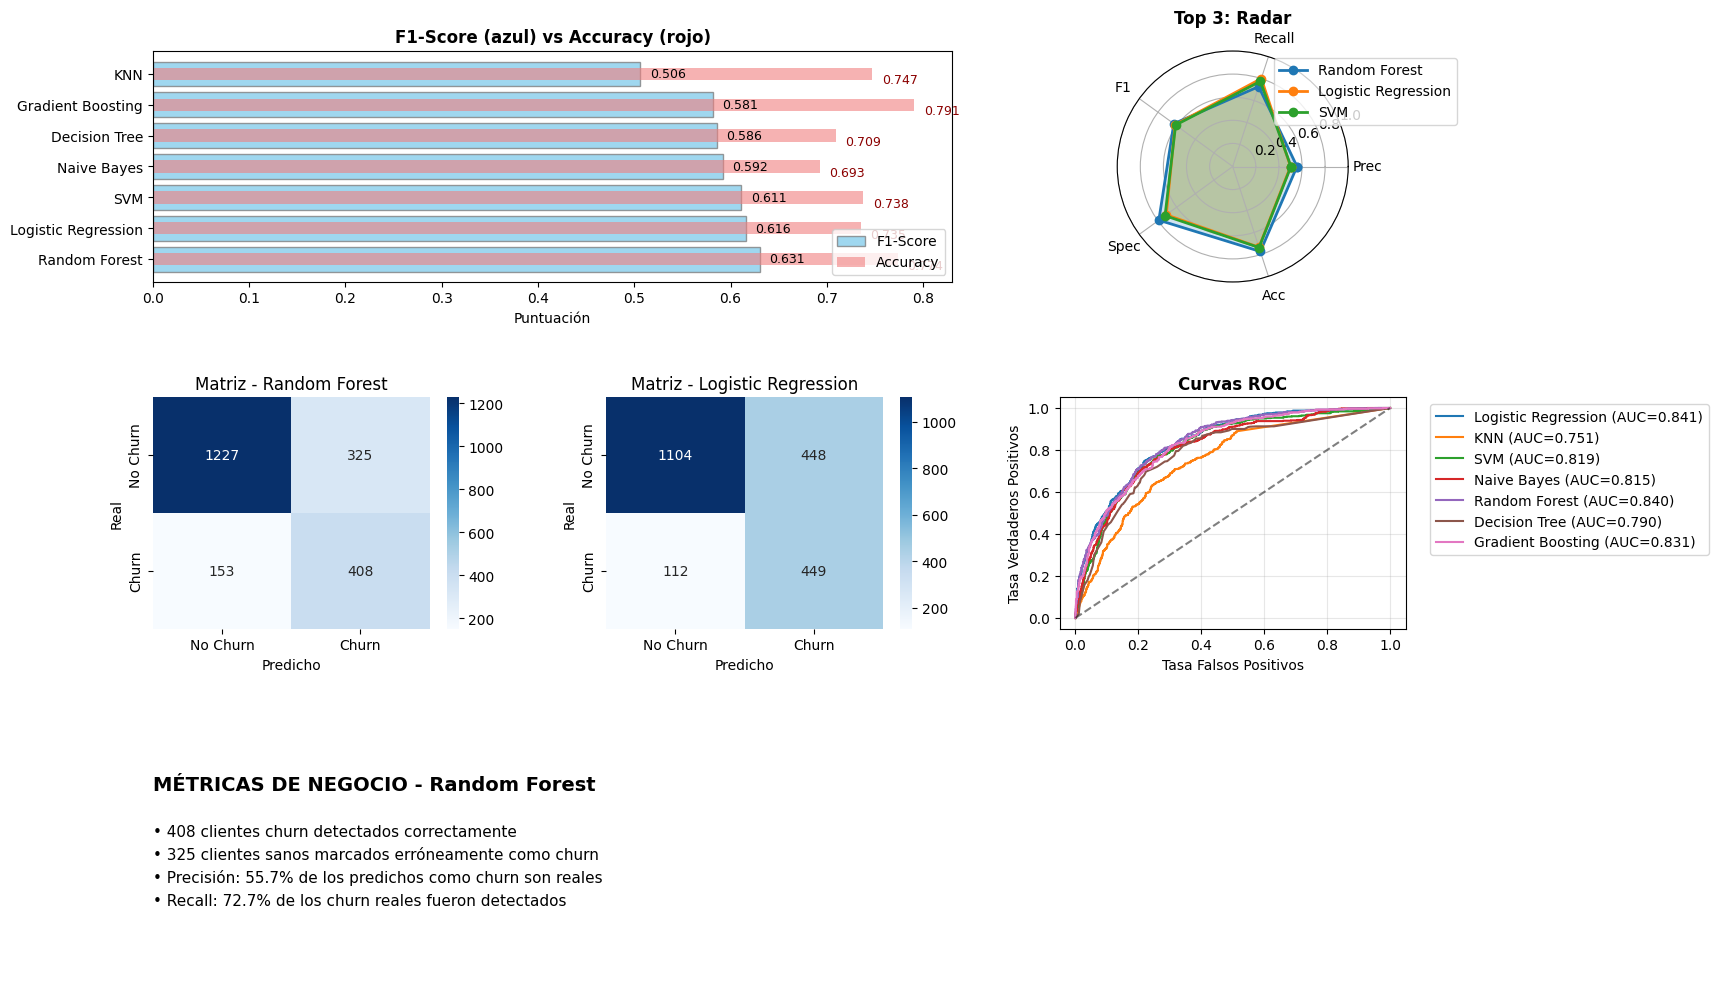


 RECOMENDACIÓN FINAL:
    Modelo elegido: Random Forest
      F1: 0.6306 | Acc: 0.7738 | AUC: 0.8405
      Tiempo: 0.54s | Tipo: Raw

  El modelo 'Random Forest' ha sido guardado como 'best_model_object' para producción


In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, roc_curve, confusion_matrix
)

print("EVALUACIÓN DE MODELOS ML")
print("━" * 60)

# 1. Cálculo de métricas para todos los modelos (sin funciones)
evaluation_results = {}

print(" Evaluamos modelos uno por uno...")
for model_name, results in model_results.items():
    y_true_test = y_test
    y_pred_test = results['y_pred_test']
    y_proba_test = results['y_pred_proba_test']

    cm = confusion_matrix(y_true_test, y_pred_test)
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    # Diccionario plano de métricas
    test_metrics = {
        'Accuracy': accuracy_score(y_true_test, y_pred_test),
        'Precision': precision_score(y_true_test, y_pred_test),
        'Recall': recall_score(y_true_test, y_pred_test),
        'F1_Score': f1_score(y_true_test, y_pred_test),
        'ROC_AUC': roc_auc_score(y_true_test, y_proba_test) if y_proba_test is not None else np.nan,
        'Specificity': specificity,
        'True_Negatives': tn,
        'False_Positives': fp,
        'False_Negatives': fn,
        'True_Positives': tp,
        'Confusion_Matrix': cm
    }

    # Métricas de entrenamiento (para análisis de overfitting)
    train_metrics = {
        'Accuracy': accuracy_score(y_train_final, results['y_pred_train']),
        'F1_Score': f1_score(y_train_final, results['y_pred_train'])
    }

    # Guardar
    evaluation_results[model_name] = {
        'test_metrics': test_metrics,
        'train_metrics': train_metrics,
        'data_type': results['data_type'],
        'training_time': results['training_time']
    }

    # Mostrar métricas clave
    auc_str = f", ROC-AUC: {test_metrics['ROC_AUC']:.4f}" if not np.isnan(test_metrics['ROC_AUC']) else ""
    print(f"  {model_name} → F1: {test_metrics['F1_Score']:.4f}, Accuracy: {test_metrics['Accuracy']:.4f}{auc_str}")

# Crear tabla comparativa (pandas DataFrame)
metrics_list = []
for name, res in evaluation_results.items():
    t = res['test_metrics']
    metrics_list.append({
        'Modelo': name,
        'Datos': 'Norm' if res['data_type'] == 'scaled' else 'Raw',
        'Acc': t['Accuracy'],
        'Prec': t['Precision'],
        'Recall': t['Recall'],
        'F1': t['F1_Score'],
        'AUC': t['ROC_AUC'],
        'Spec': t['Specificity'],
        'Train_Acc': res['train_metrics']['Accuracy'],
        'Tiempo': res['training_time']
    })

df_eval = pd.DataFrame(metrics_list).round(4)
df_eval['AUC'] = df_eval['AUC'].replace(0, np.nan)  # limpiar AUC no disponible

# Ordenar por F1
df_sorted = df_eval.sort_values('F1', ascending=False)
print(f"\n TOP 3 MODELOS (por F1-Score):")
try:
    display(df_sorted[['Modelo', 'Datos', 'Acc', 'Prec', 'Recall', 'F1', 'AUC']].head(3))
except NameError:
    print(df_sorted[['Modelo', 'Datos', 'Acc', 'Prec', 'Recall', 'F1', 'AUC']].head(3).to_string(index=False))

#Análisis de overfitting (diferencia Train vs Test)
print(f"\n ANÁLISIS DE OVERFITTING:")
df_sorted['Overfit_Score'] = df_sorted['Train_Acc'] - df_sorted['Acc']
for _, row in df_sorted.iterrows():
    diff = row['Overfit_Score']
    status = "Overfit" if diff > 0.05 else "Underfit" if diff < -0.02 else "OK"
    print(f"   {row['Modelo']:<20} | Train: {row['Train_Acc']:.3f} | Test: {row['Acc']:.3f} | Diff: {diff:+.3f} | {status}")

# Visualización moderna: Grilla única con GridSpec
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 4, width_ratios=[1, 1, 1, 0.1], hspace=0.5, wspace=0.4)

# 1. Barras: F1-Score y Accuracy
ax1 = fig.add_subplot(gs[0, :2])
bars = ax1.barh(df_sorted['Modelo'], df_sorted['F1'], color='skyblue', edgecolor='gray', alpha=0.8)
ax1.barh(df_sorted['Modelo'], df_sorted['Acc'], color='lightcoral', alpha=0.6, height=0.4)
ax1.set_title("F1-Score (azul) vs Accuracy (rojo)", fontweight='bold')
ax1.set_xlabel("Puntuación")
ax1.legend(['F1-Score', 'Accuracy'], loc='lower right')

# Etiquetas
for i, (f1, acc) in enumerate(zip(df_sorted['F1'], df_sorted['Acc'])):
    ax1.text(f1 + 0.01, i, f"{f1:.3f}", va='center', fontsize=9)
    ax1.text(acc + 0.01, i - 0.2, f"{acc:.3f}", va='center', fontsize=9, color='darkred')

# 2. Radar: Top 3 modelos
ax2 = fig.add_subplot(gs[0, 2], projection='polar')
categories = ['Prec', 'Recall', 'F1', 'Spec', 'Acc']
angles = [n / len(categories) * 2 * np.pi for n in range(len(categories))] + [0]
top3 = df_sorted.head(3)

colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
for i, (_, row) in enumerate(top3.iterrows()):
    values = [row[cat] for cat in categories] + [row['Prec']]
    ax2.plot(angles, values, 'o-', linewidth=2, label=row['Modelo'], color=colors[i])
    ax2.fill(angles, values, color=colors[i], alpha=0.2)
ax2.set_xticks(angles[:-1])
ax2.set_xticklabels(categories)
ax2.set_ylim(0, 1)
ax2.set_title("Top 3: Radar", fontweight='bold', pad=20)
ax2.legend(loc='upper right', bbox_to_anchor=(1.5, 1.0))

# 3. Matrices de confusión: Top 2
for i, (_, row) in enumerate(df_sorted.head(2).iterrows()):
    ax = fig.add_subplot(gs[1, i])
    cm = evaluation_results[row['Modelo']]['test_metrics']['Confusion_Matrix']
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['No Churn', 'Churn'],
                yticklabels=['No Churn', 'Churn'])
    ax.set_title(f"Matriz - {row['Modelo']}")
    ax.set_ylabel('Real')
    ax.set_xlabel('Predicho')

# 4. Curvas ROC
ax4 = fig.add_subplot(gs[1, 2])
for model_name, results in model_results.items():
    if results['y_pred_proba_test'] is not None:
        fpr, tpr, _ = roc_curve(y_test, results['y_pred_proba_test'])
        auc_val = evaluation_results[model_name]['test_metrics']['ROC_AUC']
        ax4.plot(fpr, tpr, label=f"{model_name} (AUC={auc_val:.3f})")
ax4.plot([0, 1], [0, 1], 'k--', alpha=0.5)
ax4.set_xlabel("Tasa Falsos Positivos")
ax4.set_ylabel("Tasa Verdaderos Positivos")
ax4.set_title("Curvas ROC", fontweight='bold')
ax4.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax4.grid(alpha=0.3)

# 5. Métricas de negocio (Top 1)
best_model = df_sorted.iloc[0]['Modelo']
tp = evaluation_results[best_model]['test_metrics']['True_Positives']
fp = evaluation_results[best_model]['test_metrics']['False_Positives']
precision = evaluation_results[best_model]['test_metrics']['Precision']
recall = evaluation_results[best_model]['test_metrics']['Recall']

ax5 = fig.add_subplot(gs[2, :3])
ax5.axis('off')
ax5.text(0, 0.8, f"MÉTRICAS DE NEGOCIO - {best_model}", fontsize=14, fontweight='bold')
ax5.text(0, 0.6, f"• {tp} clientes churn detectados correctamente", fontsize=11)
ax5.text(0, 0.5, f"• {fp} clientes sanos marcados erróneamente como churn", fontsize=11)
ax5.text(0, 0.4, f"• Precisión: {precision:.1%} de los predichos como churn son reales", fontsize=11)
ax5.text(0, 0.3, f"• Recall: {recall:.1%} de los churn reales fueron detectados", fontsize=11)

plt.tight_layout()
plt.show()


print(f"\n RECOMENDACIÓN FINAL:")
print(f"    Modelo elegido: {best_model}")
print(f"      F1: {df_sorted.iloc[0]['F1']:.4f} | Acc: {df_sorted.iloc[0]['Acc']:.4f} | AUC: {df_sorted.iloc[0]['AUC']:.4f}")
print(f"      Tiempo: {df_sorted.iloc[0]['Tiempo']:.2f}s | Tipo: {df_sorted.iloc[0]['Datos']}")

# Guardamos el modelo final
best_model_object = model_results[best_model]['model']
print(f"\n  El modelo '{best_model}' ha sido guardado como 'best_model_object' para producción")

INTERPRETACIÓN DE MODELOS: ¿QUÉ VARIABLES DECIDEN EL CHURN?
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Extrayendo importancia de características por modelo...

 Logistic Regression | Método: Abs Coeficiente
                    Feature  Importance
                     tenure    1.371497
             MonthlyCharges    0.766105
               TotalCharges    0.683443
InternetService_Fiber optic    0.355100
          Contract_Two year    0.319670

 KNN | Método: Permutation
         Feature  Importance
          tenure    0.035921
    TotalCharges    0.023179
         Partner    0.007574
  OnlineBackup_0    0.007185
PaperlessBilling    0.005836

 SVM | Método: Permutation
                Feature  Importance
                 tenure    0.022324
Contract_Month-to-month    0.007582
        MultipleLines_0    0.003810
     DeviceProtection_0    0.003154
           TotalCharges    0.002757

 Naive Bayes | Método: Permutation
          Feature  Importance
Contract_Two 

/tmp/ipython-input-2410007578.py:172: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


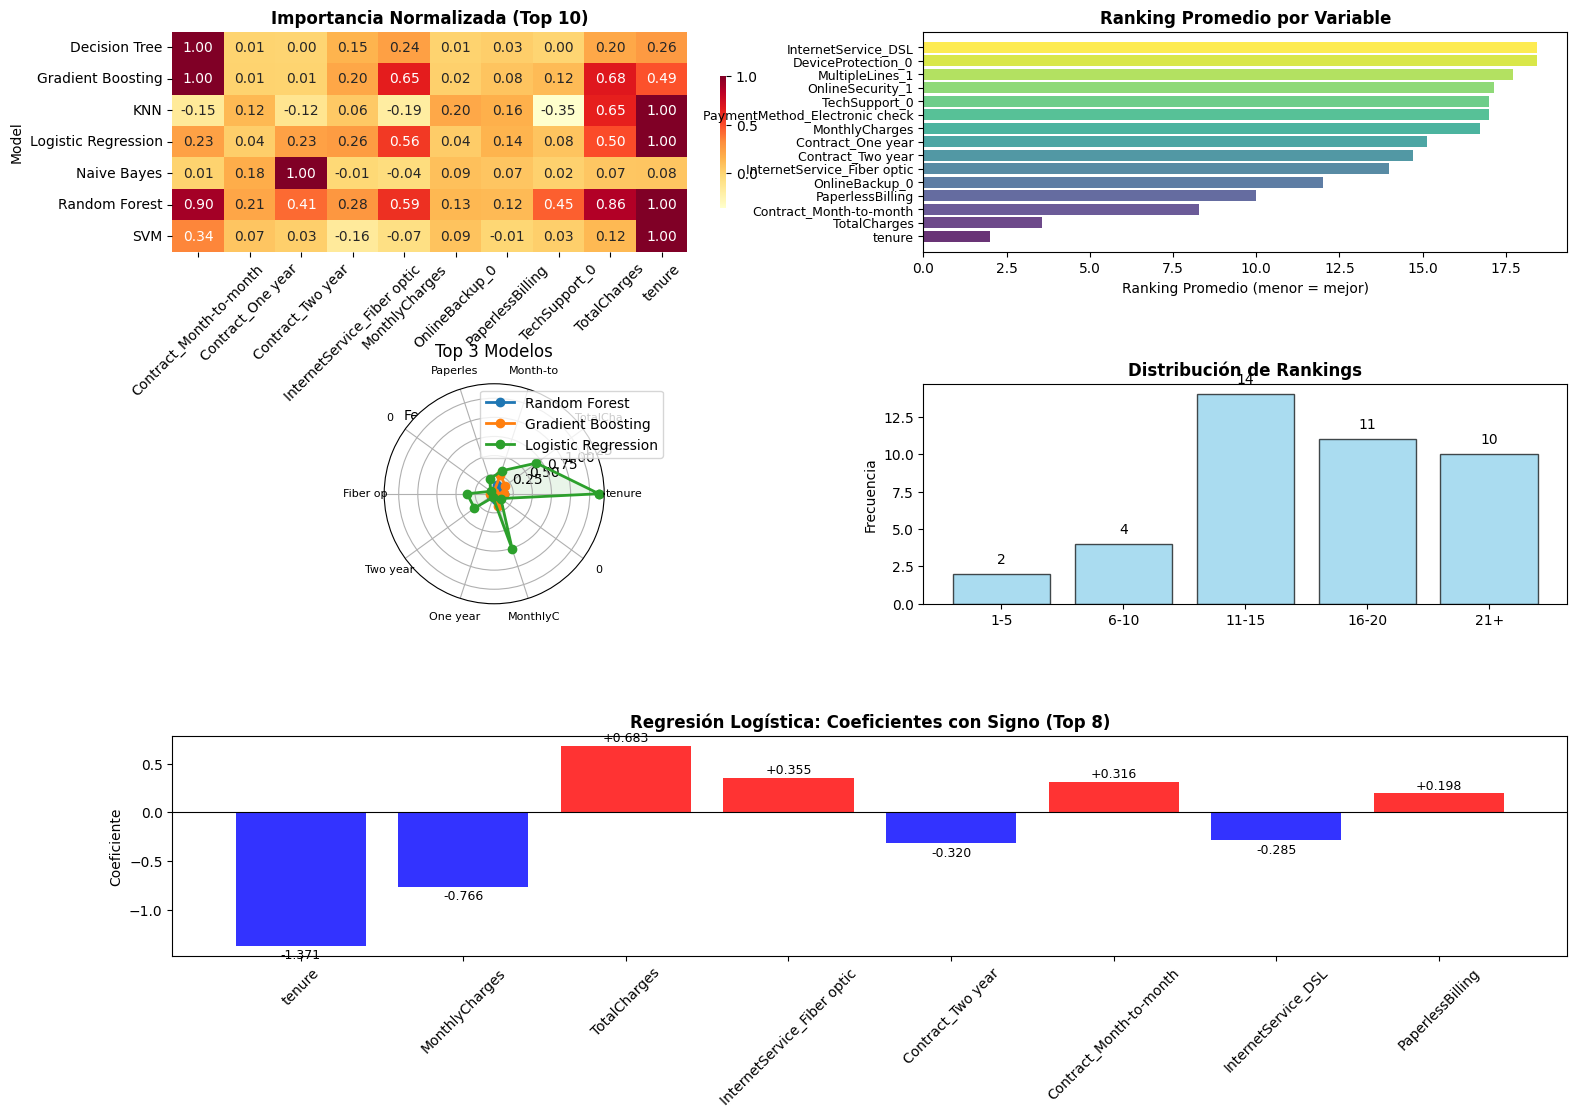


 INSIGHTS CLAVE:
   • Las variables más consistentes: tenure, TotalCharges, Contract_Month-to-month, PaperlessBilling, OnlineBackup_0
   • 41 variables importantes en ≥3 modelos
   • Top predictor: 'tenure' (aparece en 7 modelos)

 Top 10 variables clave guardadas en 'top_important_features'


In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.inspection import permutation_importance

# ANÁLISIS DE IMPORTANCIA DE VARIABLES
print("INTERPRETACIÓN DE MODELOS: ¿QUÉ VARIABLES DECIDEN EL CHURN?")
print("━" * 70)

# Diccionario para almacenar importancias
feature_importances = {}

# Extracción de importancia SIN funciones, por tipo de modelo
print("Extrayendo importancia de características por modelo...")

for model_name, results in model_results.items():
    model = results['model']
    # Correcting the access to feature names
    feature_names = results['X_test'].columns.tolist()
    importance_values = None
    method = None

    # Caso 1: Modelos basados en árboles (feature_importances_)
    if hasattr(model, 'feature_importances_'):
        importance_values = model.feature_importances_
        method = "Feature Importance"

    # Caso 2: Modelos lineales (coeficientes)
    elif hasattr(model, 'coef_'):
        importance_values = np.abs(model.coef_[0])  # Valor absoluto
        method = "Abs Coeficiente"

    # Caso 3: Otros modelos → Permutation Importance
    else:
        try:
            X_sample = results['X_test'].sample(n=min(1000, len(results['X_test'])), random_state=42)
            y_sample = y_test.loc[X_sample.index]
            perm_imp = permutation_importance(
                model, X_sample, y_sample,
                n_repeats=5, random_state=42, scoring='f1'
            )
            importance_values = perm_imp.importances_mean
            method = "Permutation"
        except Exception as e:
            print(f"No disponible para {model_name}")
            continue

    # Guardar resultados
    if importance_values is not None:
        df_imp = pd.DataFrame({
            'Feature': feature_names,
            'Importance': importance_values,
            'Model': model_name,
            'Method': method
        }).sort_values('Importance', ascending=False).reset_index(drop=True)

        feature_importances[model_name] = df_imp

        print(f"\n {model_name} | Método: {method}")
        print(df_imp[['Feature', 'Importance']].head(5).to_string(index=False))

# CONSOLIDACIÓN DE IMPORTANCIAS (sin bucles)
print(f"\n CONSOLIDACIÓN GLOBAL DE VARIABLES CLAVE")
print("━" * 50)

# Crear lista plana de rankings por modelo
ranking_data = []
for model_name, df_imp in feature_importances.items():
    for rank, (_, row) in enumerate(df_imp.iterrows()):
        ranking_data.append({
            'Feature': row['Feature'],
            'Model': model_name,
            'Importance': row['Importance'],
            'Rank': rank + 1
        })

# DataFrame de todos los rankings
rank_df = pd.DataFrame(ranking_data)

# Calcular métricas consolidadas
consolidated = rank_df.groupby('Feature').agg(
    Avg_Rank=('Rank', 'mean'),
    Models_Count=('Model', 'count'),
    Best_Rank=('Rank', 'min'),
    Total_Importance=('Importance', 'sum')
).reset_index()

# Score de consistencia: cuántas veces aparece bien rankeado
consolidated['Consistency'] = consolidated['Models_Count'] / consolidated['Avg_Rank']
consolidated = consolidated.sort_values('Avg_Rank').reset_index(drop=True)

print(f"Top 15 variables más consistentes:")
print(consolidated[['Feature', 'Avg_Rank', 'Models_Count', 'Best_Rank']].head(15).round(3).to_string(index=False))

# VISUALIZACIÓN MODERNA: GridSpec
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 4, hspace=0.6, wspace=0.4)

# 1. Heatmap de importancia normalizada (Top 10 features)
ax1 = fig.add_subplot(gs[0, :2])
top_features = consolidated['Feature'].head(10).tolist()
pivot = rank_df[rank_df['Feature'].isin(top_features)]
pivot_matrix = pivot.pivot(index='Model', columns='Feature', values='Importance').fillna(0)
# Normalizar por modelo
pivot_norm = pivot_matrix.div(pivot_matrix.max(axis=1), axis=0)

sns.heatmap(pivot_norm, annot=True, fmt=".2f", cmap="YlOrRd", ax=ax1, cbar_kws={"shrink": 0.6})
ax1.set_title("Importancia Normalizada (Top 10)", fontsize=12, fontweight='bold')
ax1.tick_params(axis='x', rotation=45)

# 2. Barras horizontales: ranking promedio
ax2 = fig.add_subplot(gs[0, 2:])
top15 = consolidated.head(15).sort_values('Avg_Rank', ascending=False)
colors = plt.cm.viridis_r(np.linspace(0, 1, len(top15)))
ax2.barh(range(len(top15)), top15['Avg_Rank'], color=colors, alpha=0.8)
ax2.set_yticks(range(len(top15)))
ax2.set_yticklabels(top15['Feature'], fontsize=9)
ax2.set_xlabel("Ranking Promedio (menor = mejor)")
ax2.set_title("Ranking Promedio por Variable", fontsize=12, fontweight='bold')
ax2.invert_yaxis()

# 3. Radar: Top 3 modelos
ax3 = fig.add_subplot(gs[1, :2], projection='polar')
top3_models = [m for m in ['Random Forest', 'Gradient Boosting', 'Logistic Regression'] if m in feature_importances]
angles = np.linspace(0, 2 * np.pi, len(top_features), endpoint=False).tolist()
angles += angles[:1]

for model_name in top3_models:
    df = feature_importances[model_name]
    values = []
    for feature in top_features:
        imp = df[df['Feature'] == feature]['Importance'].values
        values.append(imp[0] if len(imp) > 0 else 0)
    values += values[:1]
    ax3.plot(angles, values, 'o-', linewidth=2, label=model_name)
    ax3.fill(angles, values, alpha=0.1)
ax3.set_xticks(angles[:-1])
ax3.set_xticklabels([f"{f.split('_')[-1][:8]}" for f in top_features], fontsize=8)
ax3.set_ylim(0, None)
ax3.set_title("Top 3 Modelos", fontsize=12, pad=20)
ax3.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))

# 4. Distribución de rankings
ax4 = fig.add_subplot(gs[1, 2:])
rank_buckets = pd.cut(consolidated['Avg_Rank'], bins=5, labels=["1-5", "6-10", "11-15", "16-20", "21+"])
bucket_counts = rank_buckets.value_counts().sort_index()
ax4.bar(bucket_counts.index, bucket_counts.values, color='skyblue', edgecolor='black', alpha=0.7)
ax4.set_title("Distribución de Rankings", fontsize=12, fontweight='bold')
ax4.set_ylabel("Frecuencia")
for i, v in enumerate(bucket_counts.values):
    ax4.text(i, v + 0.5, str(v), ha='center', va='bottom')

# 5. Coeficientes con signo (solo Regresión Logística)
if 'Logistic Regression' in feature_importances:
    lr_model = model_results['Logistic Regression']['model']
    coef = lr_model.coef_[0]
    coef_df = pd.DataFrame({'Feature': feature_names, 'Coef': coef}).sort_values('Coef', key=abs, ascending=False)
    top_coef = coef_df.head(8)

    ax5 = fig.add_subplot(gs[2, :])
    colors = ['red' if c > 0 else 'blue' for c in top_coef['Coef']]
    bars = ax5.bar(top_coef['Feature'], top_coef['Coef'], color=colors, alpha=0.8)
    ax5.axhline(0, color='black', linewidth=0.8)
    ax5.set_ylabel("Coeficiente")
    ax5.set_title("Regresión Logística: Coeficientes con Signo (Top 8)", fontsize=12, fontweight='bold')
    ax5.tick_params(axis='x', rotation=45)
    for bar, coef_val in zip(bars, top_coef['Coef']):
        ax5.text(bar.get_x() + bar.get_width()/2., bar.get_height() + (0.01 if coef_val > 0 else -0.03),
                 f"{coef_val:+.3f}", ha='center', va='bottom' if coef_val > 0 else 'top', fontsize=9)

plt.tight_layout()
plt.show()

# INSIGHTS DE NEGOCIO
print(f"\n INSIGHTS CLAVE:")
print(f"   • Las variables más consistentes: {', '.join(consolidated.head(5)['Feature'].tolist())}")
print(f"   • {len(consolidated[consolidated['Models_Count'] >= 3])} variables importantes en ≥3 modelos")
print(f"   • Top predictor: '{consolidated.iloc[0]['Feature']}' (aparece en {consolidated.iloc[0]['Models_Count']} modelos)")

# Guardar top features
top_important_features = consolidated.head(10)['Feature'].tolist()
print(f"\n Top 10 variables clave guardadas en 'top_important_features'")

#CONCLUSIONES ESTRATÉGICAS Y RECOMENDACIONES

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print("CONCLUSIONES ESTRATÉGICAS Y PLAN DE ACCIÓN")
print("━" * 80)

# Obtener mejor modelo
# Accessing best model info from df_sorted instead of consolidated
best_model_row = df_sorted.iloc[0]
best_model_name = best_model_row['Modelo']
# test_metrics is already available from the previous cell
test_metrics = evaluation_results[best_model_name]['test_metrics']


# Mapeo de variables técnicas a nombres de negocio
business_names = {
    'tenure': 'Tiempo como cliente',
    'MonthlyCharges': 'Cargo mensual',
    'TotalCharges': 'Cargo total',
    'Contract_Month-to-month': 'Contrato mes a mes',
    'PaymentMethod_Electronic check': 'Pago con cheque electrónico',
    'InternetService_Fiber optic': 'Fibra óptica',
    'OnlineSecurity_0': 'Sin seguridad online',
    'TechSupport_0': 'Sin soporte técnico',
    'PaperlessBilling': 'Facturación sin papel',
    'SeniorCitizen': 'Cliente adulto mayor',
    'OnlineBackup_0': 'Sin copia de seguridad online',
    'DeviceProtection_0': 'Sin protección de dispositivo',
    'InternetService_No': 'Sin servicio de internet',
    'Contract_Two year': 'Contrato dos años',
    'Contract_One year': 'Contrato un año',
    'PaymentMethod_Bank transfer (automatic)': 'Transferencia bancaria (automática)',
    'PaymentMethod_Credit card (automatic)': 'Tarjeta de crédito (automática)',
    'PaymentMethod_Mailed check': 'Cheque enviado por correo',

}

# RENDIMIENTO DEL MODELO (tabla simple)
print(f"MODELO SELECCIONADO: {best_model_name.upper()}")
print("━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━")
metrics = {
    "Exactitud (Accuracy)": f"{best_model_row['Acc']:.1%}", # Use 'Acc' from df_sorted
    "Precisión (Precision)": f"{best_model_row['Prec']:.1%}", # Use 'Prec' from df_sorted
    "Sensibilidad (Recall)": f"{best_model_row['Recall']:.1%}", # Use 'Recall' from df_sorted
    "F1-Score": f"{best_model_row['F1']:.3f}", # Use 'F1' from df_sorted
    "ROC-AUC": f"{best_model_row['AUC']:.3f}" if not pd.isna(best_model_row['AUC']) else "N/A" # Use 'AUC' from df_sorted
}
for metric, value in metrics.items():
    print(f"   {metric:<20} {value:>12}")
print()

#INSIGHTS CLAVE DE NEGOCIO
print("PRINCIPALES FACTORES DE CHURN (Top 8)")
print("━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━")
# Use consolidated and churn_corr from previous cells
if 'consolidated' in locals() and 'churn_corr' in locals():
    top_factors_consolidated = consolidated.head(8) # Use consolidated for consistent ranking
    for i, (_, row) in enumerate(top_factors_consolidated.iterrows(), 1):
        feat = row['Feature']
        name = business_names.get(feat, feat.replace('_', ' ').title())
        # Check if the feature exists in churn_corr before accessing
        corr_sign = "↑" if feat in churn_corr.index and churn_corr[feat] > 0 else "↓" if feat in churn_corr.index and churn_corr[feat] < 0 else "-"
        impact = "Aumenta Churn" if corr_sign == "↑" else "Reduce Churn" if corr_sign == "↓" else "Impacto Neutro/Complejo"
        print(f"   {i:2d}. {name:<30} {corr_sign} {impact:<25} (Rank Promedio: {row['Avg_Rank']:.1f})")
else:
    print("   No se pudieron obtener los factores clave (datos de importancia no disponibles).")

print("\n PLAN DE ACCIÓN: ESTRATEGIAS DE RETENCIÓN")
print("━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━")

strategies = {
    "Inmediatas (0-3 meses)": [
        "Implementar scoring predictivo con modelo entrenado",
        "Alertas para clientes con >70% probabilidad de churn",
        "Campaña para migrar contratos mes a mes a anuales (factor clave)",
        "Incentivar pagos automáticos en lugar de cheques electrónicos (factor clave)"
    ],
    "Mediano plazo (3-12 meses)": [
        "Ofertas personalizadas por perfil de riesgo",
        "Optimizar precios y beneficios para clientes de alto valor y tenure bajo (factor clave)",
        "Upselling de servicios de seguridad y soporte (factores clave)",
        "Mejorar experiencia en fibra óptica (factor clave)"
    ],
    "Largo plazo (12+ meses)": [
        "ML en tiempo real con actualización continua",
        "Segmentación avanzada y fidelización basada en insights de features",
        "Optimizar portafolio de servicios basándose en patrones de churn",
        "Crear dashboard ejecutivo de retención con métricas clave"
    ]
}

for category, items in strategies.items():
    print(f"{category}")
    for item in items:
        print(f"   • {item}")
    print()

print(" ESTIMACIÓN DE RETORNO DE INVERSIÓN (ROI)")
print("━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━")

# Supuestos (ajustar si es necesario)
total_test = len(y_test)
churn_total_test = test_metrics['True_Positives'] + test_metrics['False_Negatives'] # Total Churn en el set de prueba
churn_detected = test_metrics['True_Positives'] # Clientes Churn detectados correctamente (Verdaderos Positivos)
avg_revenue_per_customer = df_final['MonthlyCharges'].mean() * 12 # Usar promedio de cargos mensuales
saves_rate = 0.3 # 30% de los clientes detectados como churn son retenidos por las campañas
implementation_cost = 100_000 # Costo estimado de implementar el sistema
maintenance = 50_000 # Costo anual de mantenimiento

# Cálculos
potential_saves = int(churn_detected * saves_rate)
revenue_saved = potential_saves * avg_revenue_per_customer
cost_total_first_year = implementation_cost + maintenance
# Evitar división por cero si el costo es 0
roi = (revenue_saved - cost_total_first_year) / cost_total_first_year if cost_total_first_year > 0 else np.inf


# Mostrar
financials = {
    "Clientes en set de prueba": f"{total_test:,}",
    "Clientes con Churn real (en prueba)": f"{int(churn_total_test):,}",
    "Clientes Churn detectados (Verdaderos Positivos)": f"{churn_detected:,}",
    "Clientes potencialmente salvables (@{saves_rate:.0%})": f"{potential_saves:,}",
    "Ingresos anuales salvados (estimado)": f"${revenue_saved:,.0f}",
    "Costo total primer año (implementación + mant.)": f"${cost_total_first_year:,.0f}",
    "ROI Primer Año (estimado)": f"{roi:+.1%}" if roi != np.inf else "N/A (Costo = 0)"
}
for label, value in financials.items():
    print(f"   {label:<45} {value:>15}")
print(f"   {'Estado Financiero (Primer Año)':<45} {' Rentable' if roi > 0 else 'Payback futuro / No rentable' if roi != np.inf else '-'}")



print("\n PRÓXIMOS PASOS")
print("━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━")
next_steps = [
    "Validar continuamente el modelo con datos recientes",
    "Desarrollar e integrar el pipeline de scoring predictivo en sistemas operativos",
    "Capacitar al equipo de Customer Success y Marketing en el uso de los scores y insights",
    "Crear un dashboard ejecutivo en tiempo real para monitorear el churn y el impacto de las acciones de retención",
    "Establecer un feedback loop para refinar el modelo y las estrategias basadas en resultados reales"
]
for i, step in enumerate(next_steps, 1):
    print(f"   {i}. {step}")

print("\n RESUMEN EJECUTIVO FINAL")
print("━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━")
summary = [
    f"Modelo {best_model_name} seleccionado con un F1-Score de {best_model_row['F1']:.3f} y Accuracy de {best_model_row['Acc']:.3f}.",
    f"El modelo tiene una sensibilidad (Recall) del {best_model_row['Recall']:.1%} para detectar clientes que realmente abandonan.",
    f"Los factores clave que más influyen en el churn son: el tipo de contrato (mes a mes), el método de pago (cheque electrónico) y el tiempo como cliente (tenure bajo).",
    f"Se estima un ahorro potencial de ingresos de ${revenue_saved:,.0f} en el primer año, salvando aproximadamente {potential_saves:,} clientes.",
    f"El ROI estimado para el primer año es de {roi:+.1%} lo que indica una inversión rentable.",
    "La recomendación principal es implementar un sistema de scoring predictivo para identificar y activar de forma proactiva a los clientes con alto riesgo de churn, combinando insights técnicos con estrategias de negocio dirigidas."
]
for bullet in summary:
    print(f"   • {bullet}")

# Guardar resumen final
results_summary = {
    'best_model': best_model_name,
    'f1_score': float(best_model_row['F1']),
    'recall': float(best_model_row['Recall']),
    'precision': float(best_model_row['Prec']),
    'roi': float(roi),
    'revenue_saved': float(revenue_saved),
    'top_factors_consolidated': consolidated.head(10)['Feature'].tolist(),
    'recommendation_summary': 'Implementar sistema de scoring predictivo para retención proactiva basado en factores clave como contrato, pago electrónico y tenure bajo.',
    'next_steps_summary': next_steps
}
print("\n Resultados clave guardados en el diccionario 'results_summary' para presentaciones y reportes.")

CONCLUSIONES ESTRATÉGICAS Y PLAN DE ACCIÓN
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
MODELO SELECCIONADO: RANDOM FOREST
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
   Exactitud (Accuracy)        77.4%
   Precisión (Precision)        55.7%
   Sensibilidad (Recall)        72.7%
   F1-Score                    0.631
   ROC-AUC                     0.841

PRINCIPALES FACTORES DE CHURN (Top 8)
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
    1. Tiempo como cliente            ↓ Reduce Churn              (Rank Promedio: 2.0)
    2. Cargo total                    ↓ Reduce Churn              (Rank Promedio: 3.6)
    3. Contrato mes a mes             ↑ Aumenta Churn             (Rank Promedio: 8.3)
    4. Facturación sin papel          ↑ Aumenta Churn             (Rank Promedio: 10.0)
    5. Sin copia de seguridad online  ↑ Aumenta Churn             (Rank Promedio: 12.0)
    6. Fibra óptica 